In [135]:
#https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [136]:
import numpy as np
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                        parse_dates=["Date"],
                        index_col=["Date"])

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [138]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


Text(0.5, 1.0, 'Price of bitcoin')

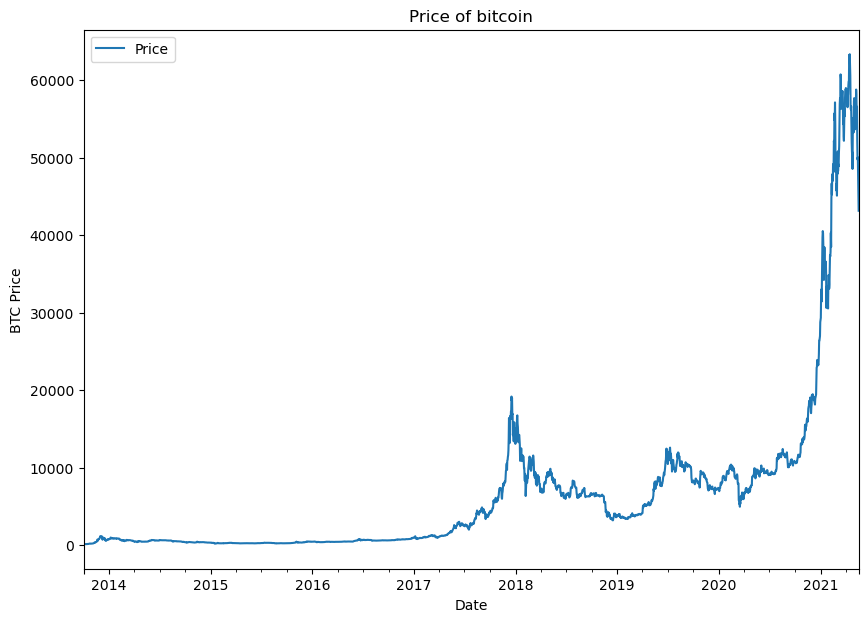

In [139]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of bitcoin")

In [140]:
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [141]:
#011 Reading in our Bitcoin data with Python's CSV module
#012 Creating train and test splits for time series (the wrong way)
#013 Creating train and test splits for time series (the right way)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bitcoin_prices.index.to_numpy(), bitcoin_prices['Price'].to_numpy(), test_size=0.2,shuffle=False, random_state=42)

In [142]:
# #The other way
# timesteps = bitcoin_prices.index.to_numpy()
# prices = bitcoin_prices["Price"].to_numpy()
# split_size = int(0.8 * len(prices)) # 80% train, 20% test
# X_train, y_train = timesteps[:split_size], prices[:split_size]
# X_test, y_test = timesteps[split_size:], prices[split_size:]
#
# len(X_train), len(X_test), len(y_train), len(y_test)

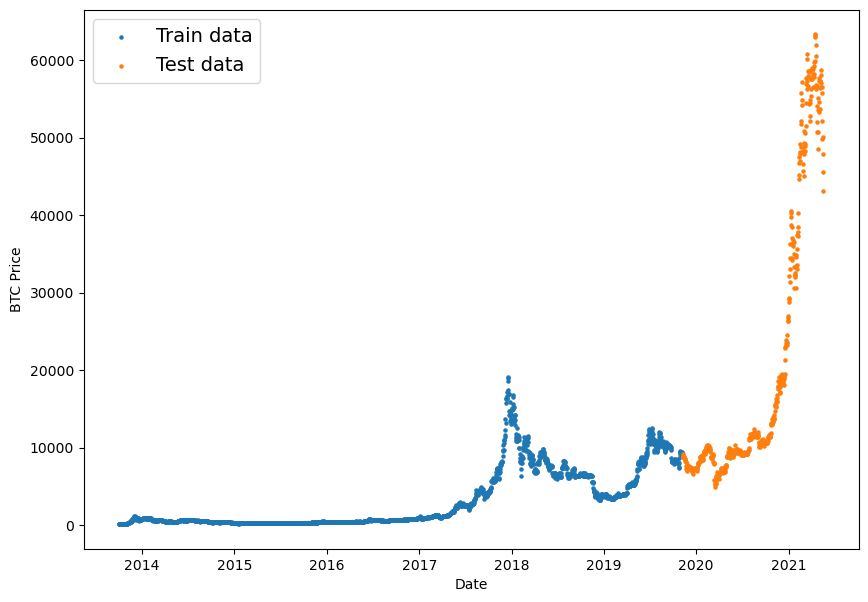

In [143]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

In [144]:
#014 Creating a plotting function to visualize our time series data
def plot_time_series(timesteps,values,format=".",start=0,end = None,label=None):
    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)


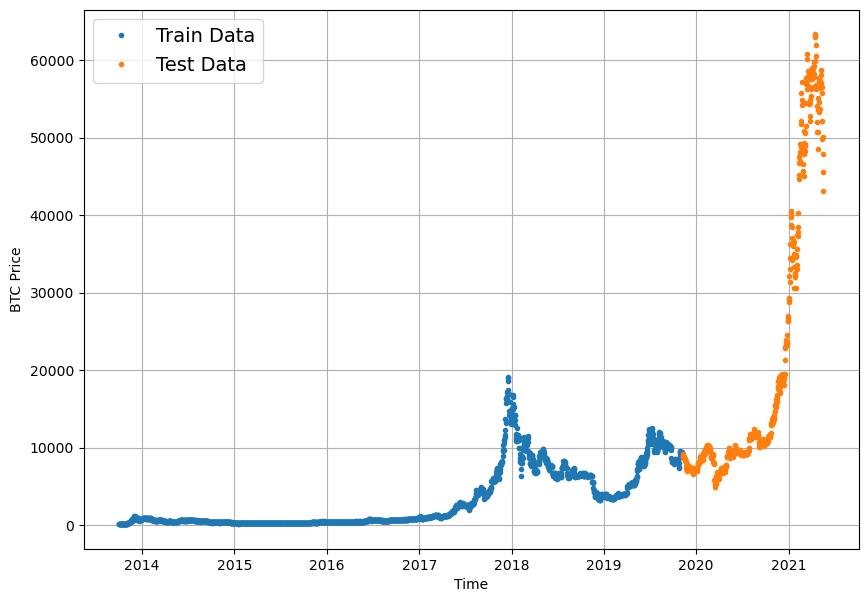

In [145]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train Data")
plot_time_series(timesteps=X_test,values=y_test,label="Test Data")

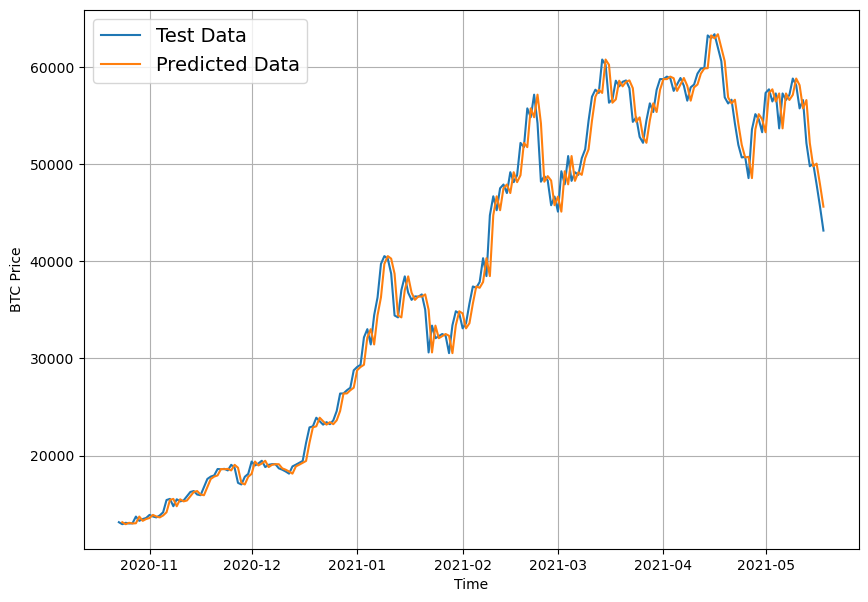

In [146]:
#015 Discussing the various modelling experiments were going to be running
#016 Model 0 Making and visualizing a naive forecast model
# naive forecast at time t is the value at (t-1)
naive_forecast = y_test[:-1]
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train,values=y_train,label="Train Data")
plot_time_series(timesteps=X_test,values=y_test,start=350,format="-",label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,start=350,format="-",label="Predicted Data")


In [147]:
#017 Discussing some of the most common time series evaluation metrics
#018 Implementing MASE with TensorFlow
import tensorflow as tf
def mean_absolute_scaled_error(y_true,y_pred):

    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    return mae / mae_naive_no_season

In [148]:
mean_absolute_scaled_error(y_true=y_test[1:],y_pred=naive_forecast).numpy()

0.9995699939182624

In [149]:
#019 Creating a function to evaluate our model's forecasts with various metrics
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)

    return {"mae":mae.numpy(),
            "mse":mse.numpy(),
            "rmse":rmse.numpy(),
            "mape":mape.numpy(),
            "mase":mase.numpy()}

In [150]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [151]:
#020 Discussing other non-TensorFlow kinds of time series forecasting models
#021 Formatting data Part 2 Creating a function to label our windowed time series
bitcoin_prices['Price'].to_numpy()[:7]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [152]:
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_window(x,horizon=HORIZON):
    return x[:,:-horizon],x[:,-horizon:]

In [153]:
#022 Discussing the use of windows and horizons in time series data
#023 Writing a preprocessing function to turn time series data into windows & labels
import numpy as np
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
    window_step=np.expand_dims(np.arange(window_size+horizon),axis=0)
    window_indexes = window_step +np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
    windowed_array = x[window_indexes]
    windows,labels = get_labelled_window(windowed_array,horizon=horizon)
    return windows,labels

In [154]:
full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)

In [155]:
full_windows

array([[  123.65499   ,   125.455     ,   108.58483   , ...,
          121.33866   ,   120.65533   ,   121.795     ],
       [  125.455     ,   108.58483   ,   118.67466   , ...,
          120.65533   ,   121.795     ,   123.033     ],
       [  108.58483   ,   118.67466   ,   121.33866   , ...,
          121.795     ,   123.033     ,   124.049     ],
       ...,
       [58788.20967893, 58102.19142623, 55715.54665129, ...,
        52147.82118698, 49764.1320816 , 50032.69313676],
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361]])

In [156]:
#Insted of above , the below can also be used
# data = [x for x in range(21)]
# input_data = data[:-3]
# targets = data[3:]
# dataset = tf.keras.utils.timeseries_dataset_from_array(
#     input_data, targets, sequence_length=3)
#
# for batch in dataset:
#   inputs, targets = batch
#   print(inputs,targets)

In [157]:
#024 Turning our windowed time series data into training and test sets
def make_train_test_splits(windows,labels,test_split=0.2):
    split_size = int(len(windows)*(1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows,test_windows,train_labels,test_labels

In [158]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [159]:
#025 Creating a modelling checkpoint callback to save our best performing model
import os

def create_model_checkpoint(model_name,save_path = "model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),verbose=0,save_best_only=True,monitor='val_loss',)

In [160]:
#026 Model 1 Building, compiling and fitting a deep learning model on Bitcoin data
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON,activation = 'linear')
],name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mse'])

model_1.fit(x = train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,

            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 4943.3804 - mae: 4943.3804 - mse: 50130828.0000INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 58ms/step - loss: 2899.8276 - mae: 2899.8276 - mse: 22382674.0000 - val_loss: 6801.2681 - val_mae: 6801.2681 - val_mse: 82423864.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 827.7151 - mae: 827.7151 - mse: 2075533.5000INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 29ms/step - loss: 429.9512 - mae: 429.9512 - mse: 648919.8750 - val_loss: 1099.7395 - val_mae: 1099.7395 - val_mse: 3713141.5000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 148.9774 - mae: 148.9774 - mse: 76043.8672INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 27ms/step - loss: 191.0377 - mae: 191.0377 - mse: 164345.8281 - val_loss: 911.4000 - val_mae: 911.4000 - val_mse: 2766973.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 219.8860 - mae: 219.8860 - mse: 263190.4062INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 27ms/step - loss: 160.3318 - mae: 160.3318 - mse: 134311.6250 - val_loss: 856.0627 - val_mae: 856.0627 - val_mse: 2500796.7500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 171.7429 - mae: 171.7429 - mse: 106390.1172INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 28ms/step - loss: 151.5087 - mae: 151.5087 - mse: 123106.8750 - val_loss: 823.5654 - val_mae: 823.5654 - val_mse: 2276633.2500
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 107.7175 - mae: 107.7175 - mse: 43810.3789INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 29ms/step - loss: 146.5906 - mae: 146.5906 - mse: 118630.6016 - val_loss: 819.6426 - val_mae: 819.6426 - val_mse: 2314820.2500
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 177.3058 - mae: 177.3058 - mse: 232907.8750INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 51ms/step - loss: 144.5799 - mae: 144.5799 - mse: 115408.6016 - val_loss: 806.4141 - val_mae: 806.4141 - val_mse: 2173338.0000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 116.6957 - mae: 116.6957 - mse: 55119.2969INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 143.2388 - mae: 143.2388 - mse: 113250.4062 - val_loss: 786.4308 - val_mae: 786.4308 - val_mse: 2115937.0000
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 142.1869 - mae: 142.1869 - mse: 113196.9531 - val_loss: 823.4758 - val_mae: 823.4758 - val_mse: 2141290.2500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 152.6946 - mae: 152.6946 - mse: 158112.0000INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 139.6273 - mae: 139.6273 - mse: 109320.6875 - val_loss: 765.5521 - val_mae: 765.5521 - val_mse: 2010035.6250
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 142.8593 - mae: 142.8593 - mse: 92899.2812INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 137.0580 - mae: 137.0580 - mse: 105783.7578 - val_loss: 756.1772 - val_mae: 756.1772 - val_mse: 1953894.0000
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 134.6316 - mae: 134.6316 - mse: 103026.4062 - val_loss: 802.5784 - val_mae: 802.5784 - val_mse: 2010117.1250
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 134.8177 - mae: 134.8177 - mse: 103451.7109 - val_loss: 775.5159 - val_mae: 775.5159 - val_mse: 1921376.8750
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 132.7125 - mae: 132.7125 - mse: 82248.1953INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 132.6357 - mae: 132.6357 - mse: 98980.7656 - val_loss: 750.2466 - val_mae: 750.2466 - val_mse: 1835711.7500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 126.8580 - mae: 126.8580 - mse: 62762.3477INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 130.8147 - mae: 130.8147 - mse: 97272.9219 - val_loss: 736.4750 - val_mae: 736.4750 - val_mse: 1778055.1250
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 116.1194 - mae: 116.1194 - mse: 60640.8984INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 128.7855 - mae: 128.7855 - mse: 95254.4219 - val_loss: 734.1501 - val_mae: 734.1501 - val_mse: 1750160.5000
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 114.7834 - mae: 114.7834 - mse: 60864.1406INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 127.5098 - mae: 127.5098 - mse: 93192.0156 - val_loss: 719.2271 - val_mae: 719.2271 - val_mse: 1694543.5000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 139.4112 - mae: 139.4112 - mse: 95386.2344INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 126.5230 - mae: 126.5230 - mse: 93281.4531 - val_loss: 695.3372 - val_mae: 695.3372 - val_mse: 1632584.7500
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 123.9157 - mae: 123.9157 - mse: 89980.5234 - val_loss: 716.3015 - val_mae: 716.3015 - val_mse: 1653282.2500
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 137.4381 - mae: 137.4381 - mse: 117423.2188INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 125.3184 - mae: 125.3184 - mse: 91791.6562 - val_loss: 690.0964 - val_mae: 690.0964 - val_mse: 1640268.8750
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 159.8594 - mae: 159.8594 - mse: 117480.7422INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 126.6902 - mae: 126.6902 - mse: 92466.6328 - val_loss: 671.7686 - val_mae: 671.7686 - val_mse: 1556095.3750
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 176.7425 - mae: 176.7425 - mse: 174887.1562INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 122.0054 - mae: 122.0054 - mse: 87556.7188 - val_loss: 665.3359 - val_mae: 665.3359 - val_mse: 1526632.5000
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 119.0643 - mae: 119.0643 - mse: 82064.3047INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 25ms/step - loss: 120.1810 - mae: 120.1810 - mse: 85486.9141 - val_loss: 659.8546 - val_mae: 659.8546 - val_mse: 1492177.7500
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 125.7200 - mae: 125.7200 - mse: 77784.7109INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 120.2803 - mae: 120.2803 - mse: 85210.9688 - val_loss: 657.6110 - val_mae: 657.6110 - val_mse: 1468769.1250
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 129.0631 - mae: 129.0631 - mse: 69316.5078INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 123.2694 - mae: 123.2694 - mse: 85709.3828 - val_loss: 648.6385 - val_mae: 648.6385 - val_mse: 1449523.6250
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 120.2680 - mae: 120.2680 - mse: 83262.8906 - val_loss: 694.5972 - val_mae: 694.5972 - val_mse: 1618783.7500
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 120.0902 - mae: 120.0902 - mse: 85327.6328 - val_loss: 666.0875 - val_mae: 666.0875 - val_mse: 1518946.1250
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 116.5006 - mae: 116.5006 - mse: 70127.9453INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 117.3150 - mae: 117.3150 - mse: 81976.0469 - val_loss: 643.5481 - val_mae: 643.5481 - val_mse: 1443161.1250
Epoch 29/100
18/18 [==============================] - 0s 4ms/step - loss: 117.1116 - mae: 117.1116 - mse: 81509.6016 - val_loss: 649.4257 - val_mae: 649.4257 - val_mse: 1416445.2500
Epoch 30/100
18/18 [==============================] - 0s 4ms/step - loss: 120.9831 - mae: 120.9831 - mse: 83536.5469 - val_loss: 710.5825 - val_mae: 710.5825 - val_mse: 1567569.7500
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 130.7449 - mae: 130.7449 - mse: 90076.2578 - val_loss: 840.6078 - val_mae: 840.6078 - val_mse: 1949623.0000
Epoch 32/100
18/18 [==============================] - 0s 4ms/step - loss: 133.2106 - mae: 133.2106 - mse: 87713.7188 - val_loss: 666.0850 - val_mae: 666.0850 - val_mse: 1499075.5000
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 122.5817 - mae: 122.5817 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 115.8042 - mae: 115.8042 - mse: 79566.7422 - val_loss: 617.5665 - val_mae: 617.5665 - val_mse: 1345824.5000
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 102.4721 - mae: 102.4721 - mse: 57914.7734INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 114.6004 - mae: 114.6004 - mse: 79391.8750 - val_loss: 616.0392 - val_mae: 616.0392 - val_mse: 1330929.1250
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 117.0369 - mae: 117.0369 - mse: 79578.6641 - val_loss: 648.2573 - val_mae: 648.2573 - val_mse: 1393940.6250
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 113.5816 - mae: 113.5816 - mse: 77286.4062 - val_loss: 621.5511 - val_mae: 621.5511 - val_mse: 1354119.3750
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 106.3886 - mae: 106.3886 - mse: 73154.3438INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 114.1513 - mae: 114.1513 - mse: 79465.2734 - val_loss: 612.4755 - val_mae: 612.4755 - val_mse: 1327275.5000
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 114.3597 - mae: 114.3597 - mse: 77512.2500 - val_loss: 672.9243 - val_mae: 672.9243 - val_mse: 1494179.2500
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 113.8235 - mae: 113.8235 - mse: 107596.6250INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 112.8933 - mae: 112.8933 - mse: 77288.1953 - val_loss: 603.7620 - val_mae: 603.7620 - val_mse: 1297460.2500
Epoch 41/100
18/18 [==============================] - 0s 3ms/step - loss: 111.5408 - mae: 111.5408 - mse: 75916.4062 - val_loss: 622.8168 - val_mae: 622.8168 - val_mse: 1349280.0000
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 109.4752 - mae: 109.4752 - mse: 60641.0625INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 115.6256 - mae: 115.6256 - mse: 79273.2266 - val_loss: 601.4911 - val_mae: 601.4911 - val_mse: 1285135.3750
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 112.4602 - mae: 112.4602 - mse: 76209.4141 - val_loss: 602.9705 - val_mae: 602.9705 - val_mse: 1294153.0000
Epoch 44/100
18/18 [==============================] - 0s 3ms/step - loss: 115.4428 - mae: 115.4428 - mse: 78245.1406 - val_loss: 642.1425 - val_mae: 642.1425 - val_mse: 1394315.3750
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 85.1653 - mae: 85.1653 - mse: 40628.4375INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 113.1374 - mae: 113.1374 - mse: 77506.8359 - val_loss: 596.7179 - val_mae: 596.7179 - val_mse: 1271618.2500
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 84.4661 - mae: 84.4661 - mse: 48612.1133INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 112.1846 - mae: 112.1846 - mse: 75057.8828 - val_loss: 594.7625 - val_mae: 594.7625 - val_mse: 1266773.2500
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7907 - mae: 115.7907 - mse: 79511.3984 - val_loss: 663.9156 - val_mae: 663.9156 - val_mse: 1405457.7500
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 115.5223 - mae: 115.5223 - mse: 76917.5625 - val_loss: 725.7438 - val_mae: 725.7438 - val_mse: 1565427.7500
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 187.3244 - mae: 187.3244 - mse: 147448.7812INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 114.6579 - mae: 114.6579 - mse: 77340.0859 - val_loss: 591.7937 - val_mae: 591.7937 - val_mse: 1256594.3750
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 130.4194 - mae: 130.4194 - mse: 135680.5000INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 111.6067 - mae: 111.6067 - mse: 75476.3359 - val_loss: 590.9264 - val_mae: 590.9264 - val_mse: 1254223.6250
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5704 - mae: 111.5704 - mse: 73665.8125 - val_loss: 591.3765 - val_mae: 591.3765 - val_mse: 1255603.7500
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 112.2404 - mae: 112.2404 - mse: 76214.6641 - val_loss: 601.0368 - val_mae: 601.0368 - val_mse: 1277618.1250
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 112.3869 - mae: 112.3869 - mse: 75860.4844 - val_loss: 603.2297 - val_mae: 603.2297 - val_mse: 1268606.3750
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 115.0388 - mae: 115.0388 - mse: 77334.8203 - val_loss: 608.1505 - val_mae: 608.1505 - val_mse: 1276794.8750
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 111.3309 - mae: 111.3309 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 114.5651 - mae: 114.5651 - mse: 76496.0547 - val_loss: 589.5826 - val_mae: 589.5826 - val_mse: 1238023.3750
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8161 - mae: 108.8161 - mse: 73763.1562 - val_loss: 605.0082 - val_mae: 605.0082 - val_mse: 1264091.8750
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 79.1181 - mae: 79.1181 - mse: 45444.5781INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 109.9892 - mae: 109.9892 - mse: 72165.7266 - val_loss: 582.8650 - val_mae: 582.8650 - val_mse: 1227662.5000
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 109.4728 - mae: 109.4728 - mse: 73432.0938 - val_loss: 598.3627 - val_mae: 598.3627 - val_mse: 1249277.7500
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 111.0437 - mae: 111.0437 - mse: 74372.3203 - val_loss: 680.4589 - val_mae: 680.4589 - val_mse: 1429029.8750
Epoch 65/100
18/18 [==============================] - 0s 4ms/step - loss: 115.8493 - mae: 115.8493 - mse: 77958.4922 - val_loss: 602.0849 - val_mae: 602.0849 - val_mse: 1254792.1250
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 121.6493 - mae: 121.6493 - mse: 83848.6484INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 110.7464 - mae: 110.7464 - mse: 73345.1484 - val_loss: 580.7535 - val_mae: 580.7535 - val_mse: 1219613.7500
Epoch 67/100
18/18 [==============================] - 0s 3ms/step - loss: 108.0041 - mae: 108.0041 - mse: 71802.6250 - val_loss: 667.7322 - val_mae: 667.7322 - val_mse: 1432462.8750
Epoch 68/100
18/18 [==============================] - 0s 3ms/step - loss: 116.3472 - mae: 116.3472 - mse: 73541.0547 - val_loss: 735.3153 - val_mae: 735.3153 - val_mse: 1634255.2500
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 123.7372 - mae: 123.7372 - mse: 82735.9531 - val_loss: 622.8704 - val_mae: 622.8704 - val_mse: 1311801.1250
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 119.8353 - mae: 119.8353 - mse: 80106.6719 - val_loss: 592.7843 - val_mae: 592.7843 - val_mse: 1244308.1250
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8234 - mae: 110.8234 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 112.1250 - mae: 112.1250 - mse: 73713.3203 - val_loss: 578.2991 - val_mae: 578.2991 - val_mse: 1210403.2500
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 107.6067 - mae: 107.6067 - mse: 71895.4922 - val_loss: 578.4928 - val_mae: 578.4928 - val_mse: 1212494.6250
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3276 - mae: 109.3276 - mse: 73286.3438 - val_loss: 578.4537 - val_mae: 578.4537 - val_mse: 1211870.5000
Epoch 75/100
18/18 [==============================] - 0s 3ms/step - loss: 108.5565 - mae: 108.5565 - mse: 71985.6484 - val_loss: 590.9256 - val_mae: 590.9256 - val_mse: 1227245.3750
Epoch 76/100
18/18 [==============================] - 0s 3ms/step - loss: 109.6890 - mae: 109.6890 - mse: 72873.3438 - val_loss: 580.9193 - val_mae: 580.9193 - val_mse: 1214581.3750
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 110.4364 - mae: 110.4364 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 107.8526 - mae: 107.8526 - mse: 71115.5000 - val_loss: 576.8972 - val_mae: 576.8972 - val_mse: 1205964.0000
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 108.0445 - mae: 108.0445 - mse: 72997.8047 - val_loss: 605.2448 - val_mae: 605.2448 - val_mse: 1262810.6250
Epoch 80/100
18/18 [==============================] - 0s 3ms/step - loss: 108.9004 - mae: 108.9004 - mse: 72781.8125 - val_loss: 579.6864 - val_mae: 579.6864 - val_mse: 1204559.6250
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 92.5938 - mae: 92.5938 - mse: 42246.0977INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 107.3503 - mae: 107.3503 - mse: 71508.5000 - val_loss: 574.4048 - val_mae: 574.4048 - val_mse: 1197711.8750
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 113.5740 - mae: 113.5740 - mse: 76353.8828 - val_loss: 575.7551 - val_mae: 575.7551 - val_mse: 1200351.6250
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5856 - mae: 111.5856 - mse: 74197.7734 - val_loss: 658.9655 - val_mae: 658.9655 - val_mse: 1392423.3750
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 113.7232 - mae: 113.7232 - mse: 73287.2031 - val_loss: 575.9285 - val_mae: 575.9285 - val_mse: 1200592.7500
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7739 - mae: 107.7739 - mse: 72174.8906 - val_loss: 574.4803 - val_mae: 574.4803 - val_mse: 1193887.8750
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7330 - mae: 107.7330 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 109.0188 - mae: 109.0188 - mse: 70890.5000 - val_loss: 572.5352 - val_mae: 572.5352 - val_mse: 1186985.7500
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 108.1845 - mae: 108.1845 - mse: 72231.0469 - val_loss: 602.6653 - val_mae: 602.6653 - val_mse: 1252118.2500
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 106.2291 - mae: 106.2291 - mse: 66467.5781INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 110.2049 - mae: 110.2049 - mse: 71383.3047 - val_loss: 572.4741 - val_mae: 572.4741 - val_mse: 1187490.1250
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 107.2621 - mae: 107.2621 - mse: 69473.7109 - val_loss: 611.2665 - val_mae: 611.2665 - val_mse: 1260889.1250
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 111.7932 - mae: 111.7932 - mse: 73495.2031 - val_loss: 636.7191 - val_mae: 636.7191 - val_mse: 1331561.5000
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3712 - mae: 109.3712 - mse: 73154.9062 - val_loss: 572.5612 - val_mae: 572.5612 - val_mse: 1190038.5000
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2123 - mae: 111.2123 - mse: 73051.7500 - val_loss: 595.1906 - val_mae: 595.1906 - val_mse: 1236207.2500
Epoch 94/100
18/18 [==============================] - 0s 3ms/step - loss: 110.0008 - mae: 110.0008 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 106.7025 - mae: 106.7025 - mse: 70267.5938 - val_loss: 571.0001 - val_mae: 571.0001 - val_mse: 1183322.7500
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 112.1995 - mae: 112.1995 - mse: 73087.8984 - val_loss: 621.6274 - val_mae: 621.6274 - val_mse: 1293816.2500
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3156 - mae: 109.3156 - mse: 72744.7734 - val_loss: 572.8557 - val_mae: 572.8557 - val_mse: 1190599.8750
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 108.1189 - mae: 108.1189 - mse: 71069.9688 - val_loss: 571.7975 - val_mae: 571.7975 - val_mse: 1186679.1250
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 153.0325 - mae: 153.0325 - mse: 133973.6250INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 107.0665 - mae: 107.0665 - mse: 71286.1484 - val_loss: 570.8932 - val_mae: 570.8932 - val_mse: 1182182.7500
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8938 - mae: 111.8938 - mse: 71755.7734 - val_loss: 652.8641 - val_mae: 652.8641 - val_mse: 1348758.1250


In [161]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 652.8883 - mae: 652.8883 - mse: 1348763.1250


[652.8883056640625, 652.8883056640625, 1348763.125]

In [162]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 570.9022 - mae: 570.9022 - mse: 1181948.7500


[570.9021606445312, 570.9021606445312, 1181948.75]

In [163]:
#027 Creating a function to make predictions with our trained models
def make_preds(model,input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [164]:
model_1_preds = make_preds(model_1,test_windows)

18/18 [==============================] - 0s 2ms/step


In [165]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
model_1_results

{'mae': 570.90216,
 'mse': 1181948.8,
 'rmse': 1087.1747,
 'mape': 2.5491068,
 'mase': 1.0029169}

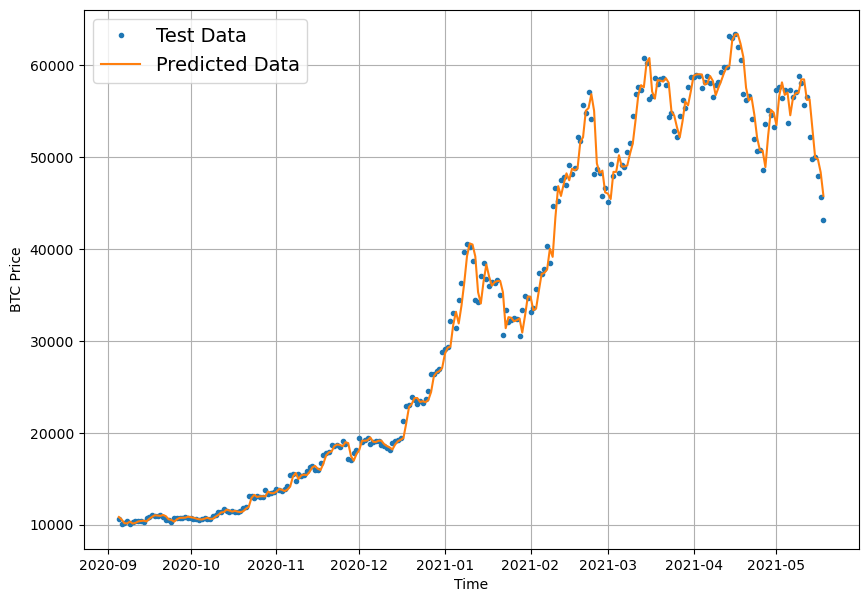

In [166]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds,start=offset,format="-",label="Predicted Data")

In [167]:
#028 Model 2 Building, fitting and evaluating a deep model with a larger window size
HORIZON = 1
WINDOW_SIZE = 30

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [168]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


In [169]:
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 637.2754 - mae: 637.2754


[637.275390625, 637.275390625]

In [170]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 605.9122 - mae: 605.9122


[605.9121704101562, 605.9121704101562]

In [171]:
model_2_preds = make_preds(model_2,input_data=test_windows,)
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_2_preds)
model_2_results

18/18 [==============================] - 0s 495us/step


{'mae': 605.9121,
 'mse': 1264140.1,
 'rmse': 1124.3398,
 'mape': 2.7381718,
 'mase': 1.0591403}

In [172]:
model_1_results

{'mae': 570.90216,
 'mse': 1181948.8,
 'rmse': 1087.1747,
 'mape': 2.5491068,
 'mase': 1.0029169}

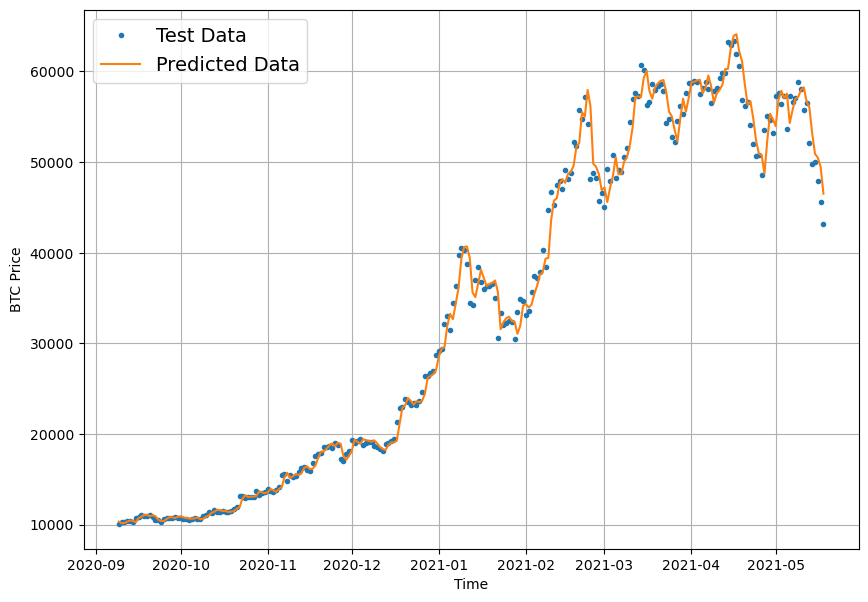

In [173]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_2_preds,start=offset,format="-",label="Predicted Data")

In [174]:
#029 Model 3 Building, fitting and evaluating a model with a larger horizon size
HORIZON = 7
WINDOW_SIZE = 30

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [175]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name= 'model_3_dense')

model_3.compile(loss='MAE',
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


In [176]:
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1423.6862


1423.6861572265625

In [177]:
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1250.2394


1250.2393798828125

In [178]:
model_3_preds = make_preds(model_3,input_data=test_windows)

18/18 [==============================] - 0s 94us/step


In [179]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  733.96875 ,   462.8019  ,   563.5     ,   727.6927  ,
          560.68317 ,   506.53342 ,   568.54895 ,   625.1107  ,
          688.0666  ,   685.041   ,   890.6932  ,   885.1925  ,
          894.0268  ,   841.1475  ,   561.5355  ,   365.21957 ,
          232.73912 ,   208.64272 ,   154.82729 ,   188.21317 ,
          125.680595,   233.61795 ,   396.51248 ,   420.25308 ,
          233.85854 ,   203.1416  ,   141.64146 ,   139.15248 ,
          138.63867 ,   200.37437 ,   275.0568  ,   449.8845  ,
          371.79926 ,   405.07916 ,   336.93723 ,   350.7142  ,
          369.3886  ,   304.34955 ,   221.47649 ,   154.22803 ,
          389.71002 ,   109.4721  ,   101.09368 ,    95.24052 ,
          198.64774 ,    79.513466,   157.52693 ,   111.14069 ,
          105.98291 ,   139.0558  ,   139.85324 ,   149.65367 ,
          208.91566 ,   259.55972 ,   278.83517 ,   320.71225 ,
          419.19168 ,   386.3559  ,   445.44266 ,   501.48355 ,
          273.99274 ,   185.66406

In [180]:
#030 Adjusting the evaluation function to work for predictions with larger horizons

#019 Creating a function to evaluate our model's forecasts with various metrics
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)

    #Account for diff size metrics for longer horizon

    if mae.ndim>0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae":mae.numpy(),
            "mse":mse.numpy(),
            "rmse":rmse.numpy(),
            "mape":mape.numpy(),
            "mase":mase.numpy()}

In [181]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1250.2394,
 'mse': 5521798.5,
 'rmse': 1437.0411,
 'mape': 5.6947417,
 'mase': 2.2247307}

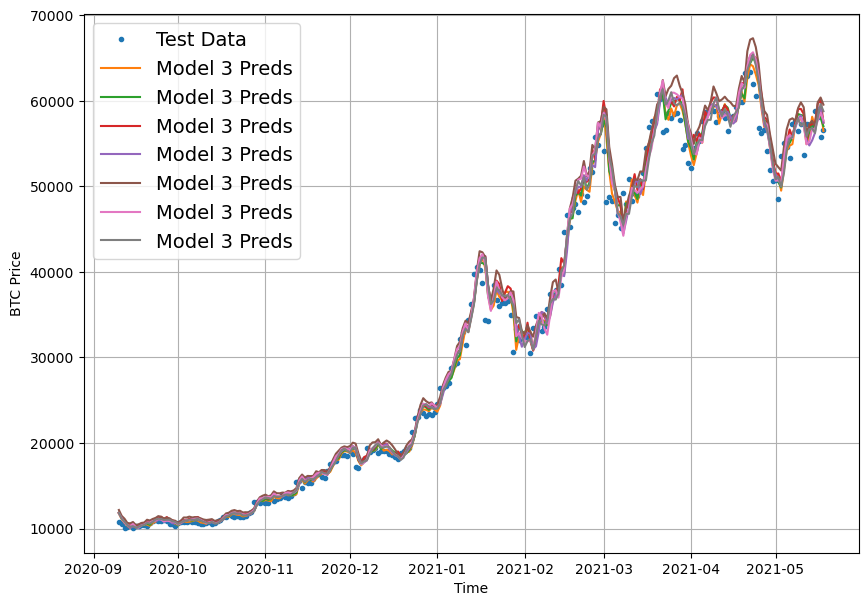

In [182]:
#031 Model 3 Visualizing the results
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_3_preds,start=offset,format='-',label="Model 3 Preds")

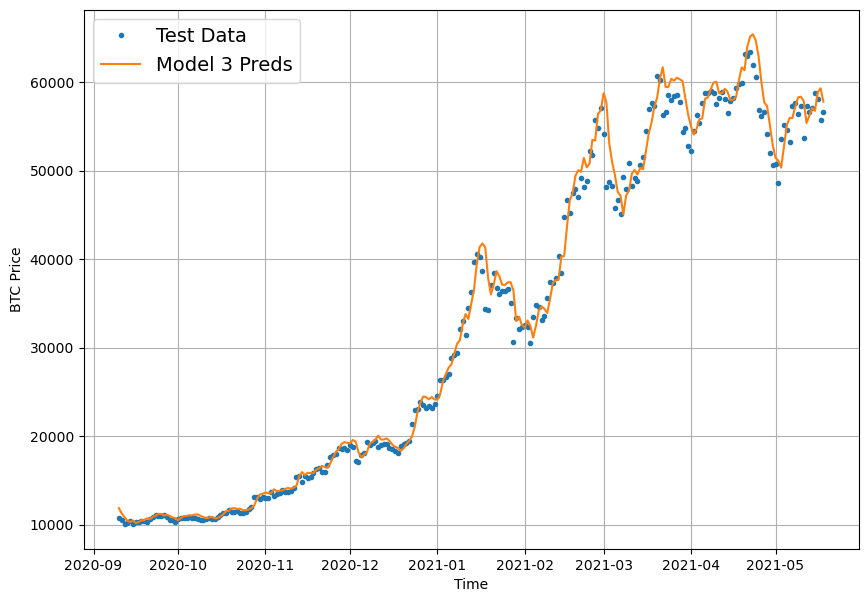

In [183]:
#031 Model 3 Visualizing the results
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=tf.reduce_mean(model_3_preds,axis=1),start=offset,format='-',label="Model 3 Preds")

<Axes: >

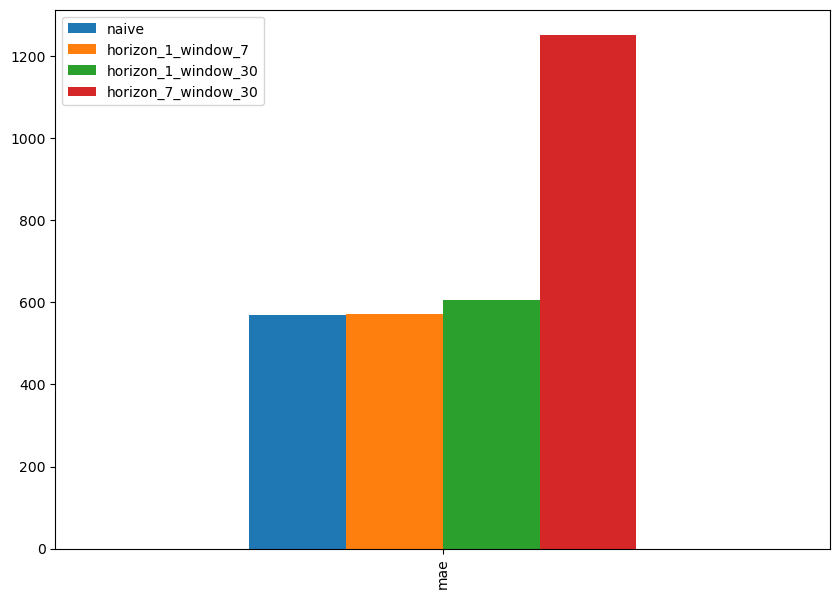

In [184]:
#032 Comparing our modelling experiments so far and discussing autocorrelation

pd.DataFrame({"naive":naive_results["mae"],
             "horizon_1_window_7":model_1_results["mae"],
             "horizon_1_window_30":model_2_results["mae"],
             "horizon_7_window_30":model_3_results["mae"],},index=['mae']).plot(figsize=(10,7),kind = "bar")


In [185]:
#033 Preparing data for building a Conv1D model
HORIZON = 1
WINDOW_SIZE = 7

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [186]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

In [187]:
#input shape : (batch_size,timesteps,input_dim)
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))

In [188]:
#034 Model 4 Building, fitting and evaluating a Conv1D model on our Bitcoin data
tf.random.set_seed(42)
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x : tf.expand_dims(x,axis=1)),
    layers.Conv1D(filters=128,kernel_size=5 , strides = 1,padding = 'causal',activation = 'relu' ),
    layers.Dense(HORIZON)
],name = "model_4_conv1D")

model_4.compile(loss="mae",optimizer=tf.keras.optimizers.Adam())
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


In [189]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_192 (Dense)           (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [190]:
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 626.4710


626.4710083007812

In [191]:
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.4586


569.4586181640625

In [192]:
model_4_preds = make_preds(model_4,test_windows)
model_4_preds

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8870.528 ,  8770.1   ,  9001.796 ,  8778.931 ,  8718.117 ,
        8738.121 ,  8672.051 ,  8524.4   ,  8452.434 ,  8512.53  ,
        8263.567 ,  8111.2427,  8060.464 ,  7694.09  ,  7317.3936,
        7261.8223,  7076.1953,  7146.061 ,  7129.3013,  7430.732 ,
        7439.183 ,  7666.7085,  7617.607 ,  7422.224 ,  7346.424 ,
        7309.855 ,  7226.776 ,  7341.1377,  7490.4985,  7537.8203,
        7558.9365,  7386.304 ,  7256.8726,  7198.108 ,  7179.0024,
        7216.6357,  7107.1475,  7094.609 ,  6923.688 ,  6630.6636,
        7229.2324,  7230.129 ,  7139.395 ,  7264.572 ,  7267.547 ,
        7204.024 ,  7212.9556,  7222.3315,  7191.7593,  7215.6567,
        7297.517 ,  7378.7915,  7286.723 ,  7193.4883,  7175.0127,
        6995.5703,  7207.0044,  7333.062 ,  7351.7944,  7651.5493,
        8010.644 ,  8116.672 ,  7894.0327,  8048.938 ,  8117.6597,
        8149.2007,  8130.125 ,  8620.148 ,  8874.292 ,  8773.476 ,
        8912.5

In [193]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_4_preds)
model_4_results

{'mae': 569.4586,
 'mse': 1179183.8,
 'rmse': 1085.9022,
 'mape': 2.546426,
 'mase': 1.0003811}

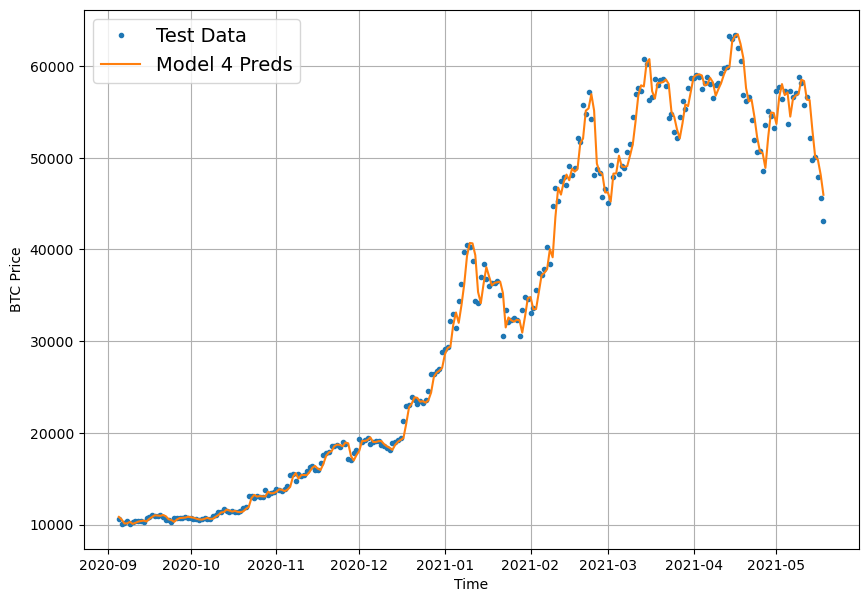

In [194]:
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_4_preds,start=offset,format='-',label="Model 4 Preds")

In [195]:
#035 Model 5 Building, fitting and evaluating a LSTM (RNN) model on our Bitcoin data
tf.random.set_seed(42)
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
#x = layers.LSTM(128,return_sequences = True)(x)
x = layers.LSTM(128,activation='relu')(x)
#x = layers.Dense(32,activation = 'relu')(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs,outputs = output,name='model_5_LSTM')

model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 2201.7556 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 80ms/step - loss: 2015.1266 - val_loss: 6533.3438
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 462.0681INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 419.6508 - val_loss: 1776.5093
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 226.9697INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 223.0088 - val_loss: 1126.6862
Epoch 4/100
13/18 [====================>.........] - ETA: 0s - loss: 202.1505INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 72ms/step - loss: 193.3209 - val_loss: 1088.9584
Epoch 5/100
11/18 [=================>............] - ETA: 0s - loss: 194.6375INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 72ms/step - loss: 186.0257 - val_loss: 1062.0504
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 182.1937INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 73ms/step - loss: 186.1989 - val_loss: 1031.1794
Epoch 7/100
13/18 [====================>.........] - ETA: 0s - loss: 194.3843INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 73ms/step - loss: 185.8795 - val_loss: 1023.3869
Epoch 8/100
13/18 [====================>.........] - ETA: 0s - loss: 181.6619INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 112ms/step - loss: 181.1988 - val_loss: 1016.3134
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 179.7015 - val_loss: 1023.3813
Epoch 10/100
12/18 [===================>..........] - ETA: 0s - loss: 172.4361INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 177.3403 - val_loss: 1001.3969
Epoch 11/100
12/18 [===================>..........] - ETA: 0s - loss: 184.2635INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 175.7214 - val_loss: 981.3285
Epoch 12/100
12/18 [===================>..........] - ETA: 0s - loss: 174.6896INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 175.6076 - val_loss: 980.4603
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 171.6407 - val_loss: 999.2763
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 169.3757 - val_loss: 989.5536
Epoch 15/100
12/18 [===================>..........] - ETA: 0s - loss: 163.8545INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 169.0597 - val_loss: 932.3125
Epoch 16/100
12/18 [===================>..........] - ETA: 0s - loss: 164.1050INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 166.0542 - val_loss: 919.3303
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 163.3440 - val_loss: 1006.2625
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 162.1832 - val_loss: 926.7241
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 157.5889 - val_loss: 929.5152
Epoch 20/100
12/18 [===================>..........] - ETA: 0s - loss: 161.5944INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 158.2836 - val_loss: 867.5056
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 154.0053 - val_loss: 873.2971
Epoch 22/100
12/18 [===================>..........] - ETA: 0s - loss: 162.7937INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 151.8166 - val_loss: 859.8774
Epoch 23/100
18/18 [==============================] - 0s 7ms/step - loss: 149.4416 - val_loss: 863.2329
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 146.0057INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 147.1455 - val_loss: 846.3784
Epoch 25/100
10/18 [===============>..............] - ETA: 0s - loss: 155.3508INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 73ms/step - loss: 145.5671 - val_loss: 811.1467
Epoch 26/100
13/18 [====================>.........] - ETA: 0s - loss: 142.3547INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 73ms/step - loss: 145.5430 - val_loss: 791.8484
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 143.9630 - val_loss: 812.9376
Epoch 28/100
11/18 [=================>............] - ETA: 0s - loss: 144.2739INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 117ms/step - loss: 141.0830 - val_loss: 775.0292
Epoch 29/100
12/18 [===================>..........] - ETA: 0s - loss: 141.5574INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 140.1451 - val_loss: 763.8512
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 140.7338 - val_loss: 908.0764
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 144.7723INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 142.7509 - val_loss: 756.7989
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 134.4122 - val_loss: 762.4549
Epoch 33/100
12/18 [===================>..........] - ETA: 0s - loss: 133.5685INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 131.6977 - val_loss: 739.1201
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 131.4337 - val_loss: 739.2887
Epoch 35/100
12/18 [===================>..........] - ETA: 0s - loss: 130.9758INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 129.4553 - val_loss: 716.5691
Epoch 36/100
11/18 [=================>............] - ETA: 0s - loss: 130.4530INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 130.1908 - val_loss: 710.0135
Epoch 37/100
12/18 [===================>..........] - ETA: 0s - loss: 123.8751INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 126.7385 - val_loss: 703.3663
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 134.1188INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 125.8581 - val_loss: 693.3286
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 127.5655 - val_loss: 730.0834
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 127.4275 - val_loss: 700.9756
Epoch 41/100
11/18 [=================>............] - ETA: 0s - loss: 129.5418INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 123.6719 - val_loss: 691.2718
Epoch 42/100
12/18 [===================>..........] - ETA: 0s - loss: 121.4335INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 123.0057 - val_loss: 682.2455
Epoch 43/100
12/18 [===================>..........] - ETA: 0s - loss: 116.3683INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 121.1494 - val_loss: 662.5906
Epoch 44/100
12/18 [===================>..........] - ETA: 0s - loss: 123.3922INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 122.8389 - val_loss: 657.7391
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 120.0531INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 118ms/step - loss: 120.1801 - val_loss: 653.3324
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 126.6679INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 120.8877 - val_loss: 650.1943
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4454 - val_loss: 655.7999
Epoch 48/100
13/18 [====================>.........] - ETA: 0s - loss: 117.0860INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 118.9745 - val_loss: 643.9791
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 117.3245 - val_loss: 645.4553
Epoch 50/100
11/18 [=================>............] - ETA: 0s - loss: 118.8874INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 120.5433 - val_loss: 633.4863
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 115.9745 - val_loss: 666.7673
Epoch 52/100
12/18 [===================>..........] - ETA: 0s - loss: 124.8170INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 116.6574 - val_loss: 628.9633
Epoch 53/100
11/18 [=================>............] - ETA: 0s - loss: 118.4718INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 117.9633 - val_loss: 626.0455
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0433 - val_loss: 655.3078
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 122.3261INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 116.8238 - val_loss: 618.8702
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 119.9594 - val_loss: 653.1700
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 125.5110 - val_loss: 636.5174
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 114.6679 - val_loss: 620.7104
Epoch 59/100
13/18 [====================>.........] - ETA: 0s - loss: 110.9463INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 113.5930 - val_loss: 613.7666
Epoch 60/100
12/18 [===================>..........] - ETA: 0s - loss: 112.9381INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 113.7131 - val_loss: 608.5302
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1341 - val_loss: 618.7568
Epoch 62/100
12/18 [===================>..........] - ETA: 0s - loss: 112.0844INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 113.5482 - val_loss: 608.3984
Epoch 63/100
11/18 [=================>............] - ETA: 0s - loss: 119.7369INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 114.5513 - val_loss: 605.9427
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 113.8533 - val_loss: 681.9660
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 117.7943 - val_loss: 608.6903
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 111.8297 - val_loss: 613.3468
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 114.0672 - val_loss: 615.0528
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 115.8280 - val_loss: 615.4861
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 120.7556 - val_loss: 662.0055
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 117.9131 - val_loss: 630.9446
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2339 - val_loss: 612.4026
Epoch 72/100
13/18 [====================>.........] - ETA: 0s - loss: 110.98

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 114ms/step - loss: 111.1735 - val_loss: 595.3499
Epoch 73/100
11/18 [=================>............] - ETA: 0s - loss: 111.8925INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 75ms/step - loss: 110.5136 - val_loss: 592.9374
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9983 - val_loss: 594.7397
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 112.7087 - val_loss: 623.3722
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 112.9146 - val_loss: 611.5901
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0935 - val_loss: 669.3497
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4559 - val_loss: 646.9725
Epoch 79/100
13/18 [====================>.........] - ETA: 0s - loss: 109.4542INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 112.3841 - val_loss: 586.7511
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 109.9694 - val_loss: 613.2169
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4750 - val_loss: 607.7963
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9778 - val_loss: 592.4210
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 111.8980 - val_loss: 602.3507
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 110.5275 - val_loss: 587.6624
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 109.2941 - val_loss: 612.2956
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4783 - val_loss: 658.0231
Epoch 87/100
13/18 [====================>.........] - ETA: 0s - loss: 118.3260INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 114.2548 - val_loss: 581.5621
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 109.6586 - val_loss: 585.9537
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 108.4731 - val_loss: 622.8195
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 114.8164 - val_loss: 689.1072
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 115.0910 - val_loss: 583.5499
Epoch 92/100
13/18 [====================>.........] - ETA: 0s - loss: 110.5002INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 110.8253 - val_loss: 579.3707
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 110.9362 - val_loss: 621.5184
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 110.4784 - val_loss: 603.2573
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 108.5000 - val_loss: 581.9523
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 109.0774 - val_loss: 581.1606
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3476 - val_loss: 619.9022
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3705 - val_loss: 584.1987
Epoch 99/100
11/18 [=================>............] - ETA: 0s - loss: 105.7615INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 108.2862 - val_loss: 577.8836
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 113.2117 - val_loss: 580.2754


In [196]:
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 577.8617


577.8616943359375

In [197]:
model_5_preds = make_preds(model_5,test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8941.35 , 8832.236, 9020.068, 8810.759, 8769.369], dtype=float32)>

In [198]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 577.8617,
 'mse': 1207063.2,
 'rmse': 1098.6643,
 'mape': 2.607747,
 'mase': 1.0151429}

In [199]:
#036 Investigating how to turn our univariate time series into multivariate
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [200]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-08")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

#037 Creating and plotting a multivariate time series with BTC price and block reward
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4


In [201]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


<Axes: xlabel='Date'>

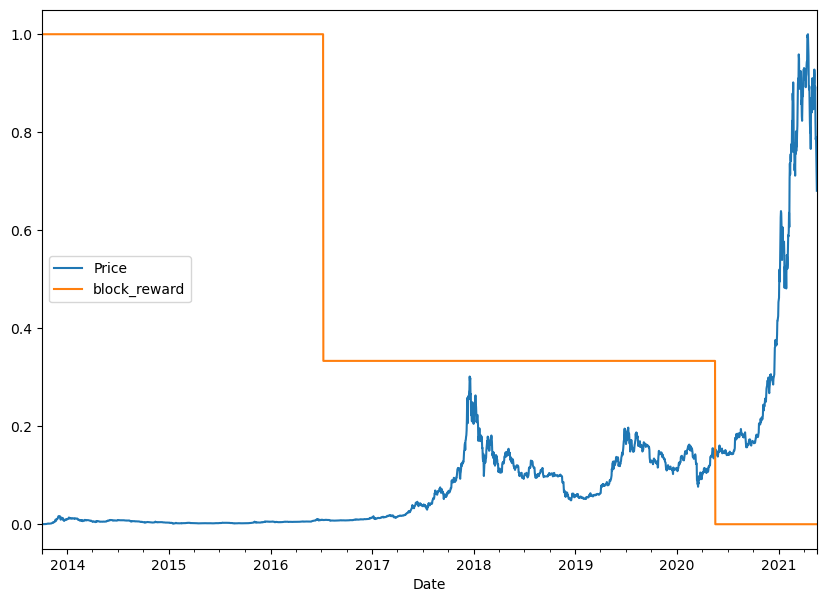

In [202]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),columns=bitcoin_prices_block.columns,index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7))

In [203]:
#038 Preparing our multivariate time series for a model
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [204]:
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)


In [205]:
split_size = int(len(X)*0.8)
X_train,y_train = X[:split_size],y[:split_size]
X_test,y_test=X[split_size:],y[split_size:]
len(X_train),len(y_train),len(X_test),len(y_test)

(2224, 2224, 556, 556)

In [206]:
#039 Model 6 Building, fitting and evaluating a multivariate time series model
tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name='model_6_dense_multivariate')

model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train,y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test,y_test),
            callbacks=create_model_checkpoint(model_name=model_6.name))

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 713.4184 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 38ms/step - loss: 674.1469 - val_loss: 1131.2505
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 160.3912INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 32ms/step - loss: 249.7789 - val_loss: 1050.5665
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 138.3269INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 172.6628 - val_loss: 840.4618
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 183.4481INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 30ms/step - loss: 152.9543 - val_loss: 742.8648
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 136.9043INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 131.1658 - val_loss: 686.1016
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 131.7981 - val_loss: 775.1561
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 126.9207 - val_loss: 703.9447
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 111.2994INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 126.0984 - val_loss: 651.2081
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 125.2743 - val_loss: 852.8140
Epoch 10/100
18/18 [==============================] - 0s 4ms/step - loss: 152.7632 - val_loss: 887.5043
Epoch 11/100
18/18 [==============================] - 0s 4ms/step - loss: 135.9904 - val_loss: 899.8449
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 144.3915INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 33ms/step - loss: 137.1954 - val_loss: 630.1904
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 84.7036INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 30ms/step - loss: 117.6538 - val_loss: 617.6829
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 108.8613INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 31ms/step - loss: 119.2252 - val_loss: 613.8015
Epoch 15/100
18/18 [==============================] - 0s 4ms/step - loss: 120.3212 - val_loss: 781.4150
Epoch 16/100
18/18 [==============================] - 0s 4ms/step - loss: 126.1039 - val_loss: 708.3172
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 121.7963 - val_loss: 618.9768
Epoch 18/100
18/18 [==============================] - 0s 4ms/step - loss: 134.5628 - val_loss: 647.0967
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 121.3713 - val_loss: 616.5418
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 140.3974INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 34ms/step - loss: 117.8167 - val_loss: 598.0508
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7139 - val_loss: 620.1949
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7277 - val_loss: 612.6855
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 119.7413 - val_loss: 598.5276
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 111.3880 - val_loss: 599.5174
Epoch 25/100
18/18 [==============================] - 0s 4ms/step - loss: 111.4974 - val_loss: 726.5995
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 127.6966INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 31ms/step - loss: 115.0209 - val_loss: 586.8773
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9572 - val_loss: 700.0991
Epoch 28/100
18/18 [==============================] - 0s 4ms/step - loss: 114.0718 - val_loss: 614.7961
Epoch 29/100
18/18 [==============================] - 0s 4ms/step - loss: 112.2454 - val_loss: 634.4617
Epoch 30/100
18/18 [==============================] - 0s 4ms/step - loss: 119.7533 - val_loss: 653.3406
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7247 - val_loss: 589.5679
Epoch 32/100
18/18 [==============================] - 0s 4ms/step - loss: 112.8279 - val_loss: 615.9527
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 138.1289INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 0s 25ms/step - loss: 108.9285 - val_loss: 578.2361
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 109.4658 - val_loss: 717.5844
Epoch 35/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5877 - val_loss: 673.6353
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9242 - val_loss: 578.9623
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 123.8024 - val_loss: 578.7649
Epoch 38/100
18/18 [==============================] - 0s 3ms/step - loss: 109.2501 - val_loss: 637.7983
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 115.5804 - val_loss: 586.6057
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2791 - val_loss: 600.9561
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3655 - val_loss: 594.3990
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 64ms/step - loss: 107.7404 - val_loss: 572.7450
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 107.1858 - val_loss: 588.2009
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 125.1755INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 0s 25ms/step - loss: 107.3243 - val_loss: 569.9012
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 89.0522INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 0s 25ms/step - loss: 110.8003 - val_loss: 566.0247
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 113.1400 - val_loss: 654.4581
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 120.3402 - val_loss: 718.3932
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 112.4121 - val_loss: 605.9948
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 111.6952 - val_loss: 572.7226
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2086 - val_loss: 833.0895
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 118.2300 - val_loss: 581.7646
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 113.2887 - val_loss: 575.8099
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 105.5978 - val_loss: 579.5970
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 10

In [207]:
model_6.evaluate(X_test,y_test)


18/18 [==============================] - 0s 1ms/step - loss: 573.4206


573.4205932617188

In [208]:
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 1ms/step - loss: 565.9618


565.9617919921875

In [209]:

model_6_preds = tf.squeeze(model_6.predict(X_test))

18/18 [==============================] - 0s 993us/step


In [210]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 565.9618,
 'mse': 1158288.0,
 'rmse': 1076.2379,
 'mape': 2.5502803,
 'mase': 0.99423814}

In [211]:
model_1_results

{'mae': 570.90216,
 'mse': 1181948.8,
 'rmse': 1087.1747,
 'mape': 2.5491068,
 'mase': 1.0029169}

In [212]:
offset = 300

prediction_df = pd.DataFrame({'Actuals':y_test,
                              'Predictions':model_6_preds})

import plotly.express as px

fig = px.line(prediction_df, x=prediction_df.index, y=list(prediction_df.columns), title='Model_6_predictions')
fig.show()


In [213]:
#040 Model 7 Discussing what we're going to be doing with the N-BEATS algorithm
# Neural basis expansion analysis for interpretable time series
#Model 7 N-BEATS
#041 Model 7 Replicating the N-BEATS basic block with TensorFlow layer subclassing
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size:int,
                 theta_size:int,
                 horizon:int,
                 n_neurons:int,
                 n_layers:int,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size=input_size
        self.theta_size=theta_size
        self.horizon=horizon
        self.n_neurons=n_neurons
        self.n_layers=n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons,activation='relu') for _ in range(n_layers)]
        self.theta_layer = tf.keras.layers.Dense(theta_size,activation='linear',name='theta')

    def call(self, inputs, *args, **kwargs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast , forecast = theta[:,:self.input_size],theta[:,-self.horizon:]
        return backcast,forecast




In [214]:
#042 Model 7 Testing our N-BEATS block implementation with dummy data inputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4,
                                       )

In [215]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [216]:
backcast,forecast = dummy_nbeats_block_layer(dummy_inputs)

In [217]:
forecast

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.3068633]], dtype=float32)>

In [218]:
#043 Model 7 Creating a performant data pipeline for the N-BEATS model with tf.data
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.head(10)

,Price,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [219]:
X = bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train,y_train = X[:split_size],y[:split_size]
X_test,y_test = X[split_size:],y[split_size:]

In [220]:
#len(X_train),len(y_train),len(X_test),len(y_test)

In [221]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)



In [222]:
#044 Model 7 Setting up hyperparameters for the N-BEATS algorithm
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON


In [223]:
#045 Model 7 Getting ready for residual connections
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtract = layers.subtract([tensor_1,tensor_2])
added = layers.add([tensor_1,tensor_2])



In [224]:
%time
#046 Model 7 Outlining the steps we're going to take to build the N-BEATS model
#047 Model 7 Putting together the pieces of the puzzle of the N-BEATS model
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")
stack_input = layers.Input(shape = (INPUT_SIZE),name="stack_input")
residuals,forecast = nbeats_block_layer(stack_input)
for i,_ in enumerate(range(N_STACKS-1)):
    backcast,block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name=f"NbeatsBlock_{i}")(residuals)

    residuals = layers.subtract([residuals,backcast],name=f"Subtract_{i}")
    forecast = layers.add([forecast,block_forecast],name=f"Add_{i}")

model_7 = tf.keras.Model(inputs=stack_input,outputs=forecast,name="Model_7_NBEATS")
model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=100,
                                                            verbose=1)])


CPU times: total: 0 ns
Wall time: 0 ns

Epoch 734: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1246: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1346: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [225]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 28ms/step - loss: 567.3143


567.3142700195312

In [226]:
model_7_preds = make_preds(model_7,test_dataset)

1/1 [==============================] - 1s 988ms/step


In [227]:
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8833.086, 8768.462, 9046.248, 8762.483, 8748.645, 8761.655,
       8659.771, 8499.377, 8476.941, 8521.262], dtype=float32)>

In [228]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 567.3143,
 'mse': 1152773.9,
 'rmse': 1073.6731,
 'mape': 2.5550678,
 'mase': 0.99661404}

In [229]:
model_1_results

{'mae': 570.90216,
 'mse': 1181948.8,
 'rmse': 1087.1747,
 'mape': 2.5491068,
 'mase': 1.0029169}

In [230]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [231]:
#048 Model 7 Plotting the N-BEATS algorithm we've created and admiring its beauty
#049 Model 8 Ensemble model overview
#050 Model 8 Building, compiling and fitting an ensemble of models
HORIZON,WINDOW_SIZE

(1, 7)

In [232]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data = test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fn=['mae','mse','mape']):
    ensamble_models = []

    for i in range(num_iter):
        for loss_function in loss_fn:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")
            model = tf.keras.Sequential([
                layers.Dense(128,kernel_initializer = "he_normal",activation = 'relu'),
                layers.Dense(128,kernel_initializer = "he_normal",activation = 'relu'),
                layers.Dense(HORIZON)

            ])

            model.compile(loss=loss_function,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae','mse'])
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=test_data,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  patience=200,
                                                                  restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                      patience=100,
                                                                      verbose=1)])
            ensamble_models.append(model)

    return ensamble_models

In [233]:
%%time
ensamble_model = get_ensemble_models(num_iter=5,
                                     num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 503: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 210: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 310: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 221: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 321: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 656: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 756: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 214: ReduceLROnPlateau reduci

In [234]:
#051 Model 8 Making and evaluating predictions with our ensemble model
def make_ensemble_preds(ensemble_models,data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [235]:
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensamble_model,
                                     data=test_dataset)

ensemble_preds

1/1 [==============================] - 0s 36ms/step
CPU times: total: 219 ms
Wall time: 668 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8775.531,  8744.517,  9038.023, ..., 50166.953, 48371.25 ,
        46561.566],
       [ 8723.889,  8714.522,  9039.128, ..., 50278.66 , 48816.586,
        46287.71 ],
       [ 8709.329,  8780.838,  9060.225, ..., 49548.04 , 48965.188,
        45425.652],
       ...,
       [ 8797.921,  8785.326,  9030.719, ..., 49934.47 , 48965.32 ,
        46240.05 ],
       [ 8817.486,  8775.578,  9032.351, ..., 50139.402, 48594.816,
        45982.684],
       [ 8776.512,  8735.521,  9059.631, ..., 49617.07 , 48724.168,
        45684.465]], dtype=float32)>

In [236]:
ensemble_mean = tf.reduce_mean(ensemble_preds,axis=0)
ensemble_median = np.median(ensemble_preds,axis=0)

In [237]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 564.7544,
 'mse': 1133002.9,
 'rmse': 1064.426,
 'mape': 2.5591464,
 'mase': 0.99211705}

In [238]:
#052 Discussing the importance of prediction intervals in forecasting
#053 Getting the upper and lower bounds of our prediction intervals
def get_upper_lower(preds):
    std = tf.math.reduce_std(preds,axis=0)
    interval = 1.96 * std
    preds_mean = tf.reduce_mean(preds,axis=0)
    lower , upper = preds_mean - interval , preds_mean+interval
    return lower,upper


In [239]:
lower,upper = get_upper_lower(preds=ensemble_preds)

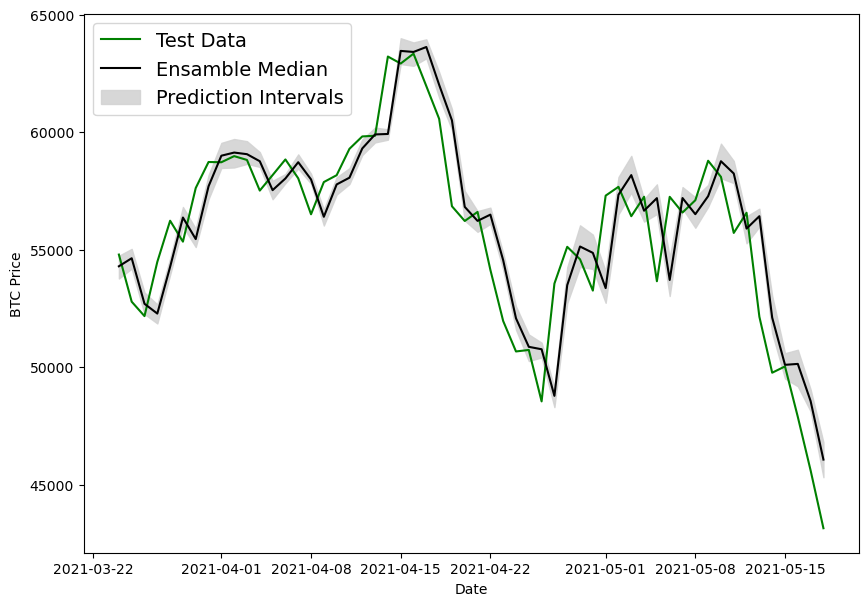

In [240]:
#054 Plotting the prediction intervals of our ensemble model predictions
ensemble_median=np.median(ensemble_preds,axis=0)
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:],y_test[offset:],"g",label="Test Data")
plt.plot(X_test.index[offset:],ensemble_median[offset:],"k-",label="Ensamble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],label="Prediction Intervals",color='#D3D3D3',alpha=0.9)

plt.legend(loc="upper left",fontsize = 14)

In [241]:
#055 (Optional) Discussing the types of uncertainty in machine learning
#056 Model 9 Preparing data to create a model capable of predicting into the future
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [242]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price","block_reward"],axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [243]:
#057 Model 9 Building, compiling and fitting a future predictions model
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_9_future_model")

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0,
            )

In [244]:
#058 Model 9 Discussing what's required for our model to make future predictions
INTO_FUTURE = 14 # predict 2 weeks into future

#059 Model 9 Creating a function to make forecasts into the future
def make_future_forecasts(values,model,into_future,window_size = WINDOW_SIZE) -> list:
    future_forecast = []
    last_window = values[-window_size:]
    for _ in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window,axis=0))
        print(f"Predicting on :\n {last_window} -> Prediction : {tf.squeeze(future_pred).numpy()}\n")

        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window,future_pred)[-window_size:]

    return future_forecast


In [245]:
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 49ms/step
Predicting on :
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction : 55709.43359375

1/1 [==============================] - 0s 20ms/step
Predicting on :
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55709.43359375] -> Prediction : 51464.9140625

1/1 [==============================] - 0s 19ms/step
Predicting on :
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55709.43359375 51464.9140625 ] -> Prediction : 50180.921875

1/1 [==============================] - 0s 15ms/step
Predicting on :
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55709.43359375 51464.9140625  50180.921875  ] -> Prediction : 47954.42578125

1/1 [==============================] - 0s 21ms/step
Predicting on :
 [47885.62525472 45604.61575361 43144.47129086 55709.43359375
 51464.9140625  50180.921875   47954.

In [246]:
#060 Model 9 Plotting our model's future forecasts
future_forecast

[55709.434,
 51464.914,
 50180.92,
 47954.426,
 47076.613,
 45913.863,
 49118.414,
 54663.293,
 50909.824,
 49049.24,
 47039.613,
 47366.926,
 48329.543,
 52074.566]

In [247]:
def get_future_dates(start_date,into_future,offset=1):
    start_date = start_date +np.timedelta64(offset,"D")
    end_date = start_date + np.timedelta64(into_future,"D")

    return np.arange(start_date,end_date,dtype="datetime64[D]")

In [248]:
last_timestep = bitcoin_prices.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [249]:
next_time_steps = np.insert(next_time_steps,0,last_timestep)
future_forecast = np.insert(future_forecast,0,bitcoin_prices['Price'][-1])

In [250]:
next_time_steps

array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
       '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
       '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

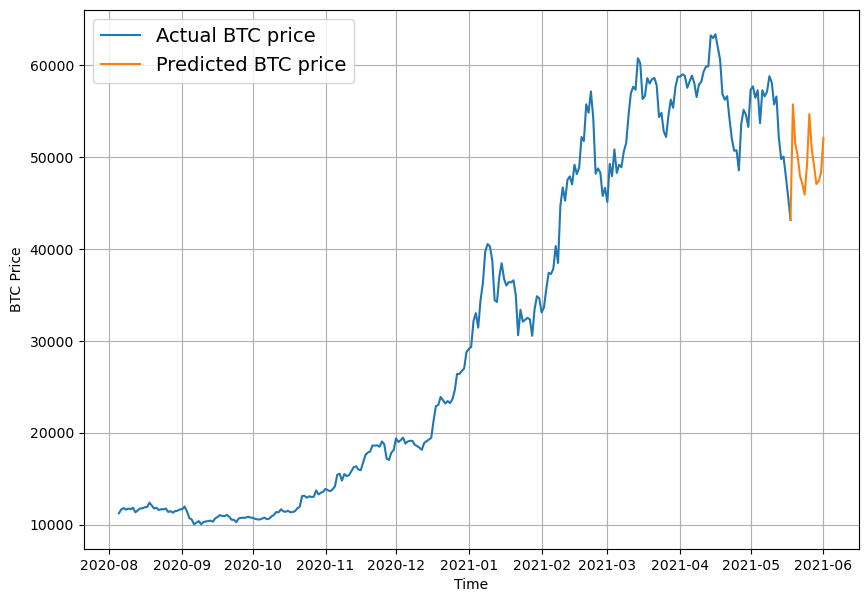

In [251]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=bitcoin_prices.index,values=bitcoin_prices,start=2500,format="-",label="Actual BTC price")
plot_time_series(timesteps=next_time_steps,values=future_forecast,format="-",label="Predicted BTC price")


In [255]:
#061 Model 10 Introducing the turkey problem and making data for it
btc_price_turkey = bitcoin_prices['Price'].tolist().copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100


In [256]:
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [258]:
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

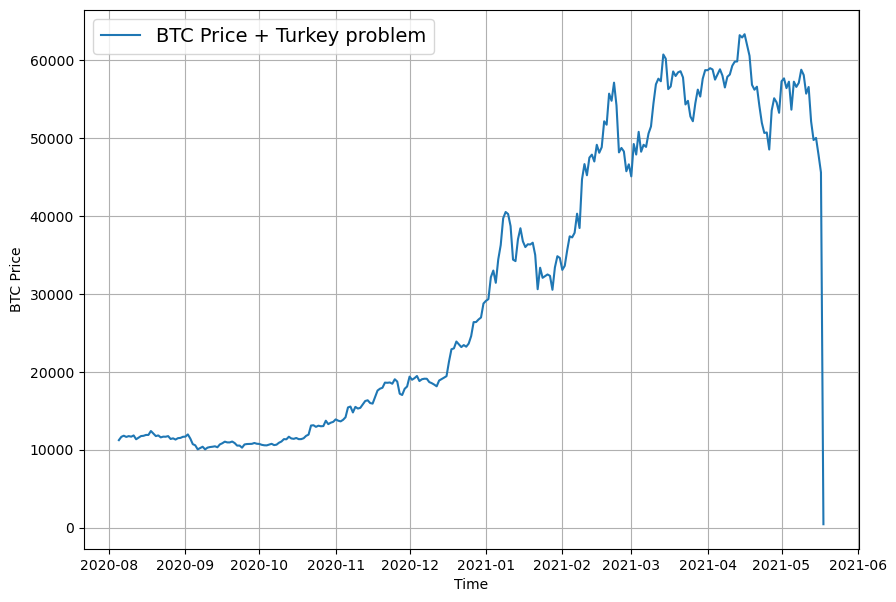

In [259]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label = "BTC Price + Turkey problem",
                 start=2500)

In [260]:
full_windows , full_labels = make_windows(np.array(btc_price_turkey),window_size=WINDOW_SIZE)
X_train,X_test,y_train,y_test = make_train_test_splits(full_windows,full_labels)


In [261]:
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss='mae',
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train,y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test,y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


In [262]:
turkey_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 738.2906


738.2905883789062

In [263]:
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 644.3193


644.3193359375

In [264]:
turkey_preds = make_preds(turkey_model,X_test)
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

18/18 [==============================] - 0s 940us/step


{'mae': 17145.475,
 'mse': 615663200.0,
 'rmse': 23747.69,
 'mape': 121.58916,
 'mase': 26.532677}